# 数据预处理

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt  # matplotlib图形展示库
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import acf,plot_acf      #自相关图
from statsmodels.graphics.tsaplots import pacf,plot_pacf     #偏自相关图
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score


plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负数的负号显示问题
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv('000625_source.csv', sep=',')
df

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2022-08-03,'000625,长安汽车,18.57,20.88,18.22,20.06,19.93,-1.36,-6.8239,7.0541,536424435,1.055425e+10,1.842478e+11,1.412147e+11
1,2022-08-02,'000625,长安汽车,19.93,20.59,19.00,19.66,20.10,-0.17,-0.8458,6.4033,486934323,9.638677e+09,1.977415e+11,1.515568e+11
2,2022-08-01,'000625,长安汽车,20.10,20.10,18.01,18.40,18.34,1.76,9.5965,6.7784,515463044,9.929775e+09,1.994282e+11,1.528495e+11
3,2022-07-29,'000625,长安汽车,18.34,18.51,17.61,17.80,17.80,0.54,3.0337,5.0166,381485655,6.935122e+09,1.819658e+11,1.394657e+11
4,2022-07-28,'000625,长安汽车,17.80,18.31,17.21,17.47,17.35,0.45,2.5937,4.386,333534226,5.942254e+09,1.766080e+11,1.353593e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6107,1997-05-29,'000625,长安汽车,0.00,0.00,0.00,0.00,6.36,None,None,None,0,0.000000e+00,3.219368e+09,0.000000e+00
6108,1997-05-28,'000625,长安汽车,0.00,0.00,0.00,0.00,6.36,None,None,None,0,0.000000e+00,3.219368e+09,0.000000e+00
6109,1997-05-27,'000625,长安汽车,0.00,0.00,0.00,0.00,6.36,None,None,None,0,0.000000e+00,3.219368e+09,0.000000e+00
6110,1997-05-26,'000625,长安汽车,0.00,0.00,0.00,0.00,6.36,None,None,None,0,0.000000e+00,3.219368e+09,0.000000e+00


## 缺失值检查

In [3]:
na_cols = df.isnull().any(axis=0)
na_cols

日期      False
股票代码    False
名称      False
收盘价     False
最高价     False
最低价     False
开盘价     False
前收盘     False
涨跌额     False
涨跌幅     False
换手率     False
成交量     False
成交金额    False
总市值     False
流通市值    False
dtype: bool

In [4]:
na_rows = df.isnull().any(axis=1)
na_rows

0       False
1       False
2       False
3       False
4       False
        ...  
6107    False
6108    False
6109    False
6110    False
6111    False
Length: 6112, dtype: bool

## 日期格式转换

In [5]:
df.iloc[:, 0]

0       2022-08-03
1       2022-08-02
2       2022-08-01
3       2022-07-29
4       2022-07-28
           ...    
6107    1997-05-29
6108    1997-05-28
6109    1997-05-27
6110    1997-05-26
6111    1997-05-23
Name: 日期, Length: 6112, dtype: object

In [6]:
data = df
data['日期'] = pd.to_datetime(data['日期'],format='%Y/%m/%d')
data.dtypes

日期      datetime64[ns]
股票代码            object
名称              object
收盘价            float64
最高价            float64
最低价            float64
开盘价            float64
前收盘            float64
涨跌额             object
涨跌幅             object
换手率             object
成交量              int64
成交金额           float64
总市值            float64
流通市值           float64
dtype: object

# 时间序列预处理

## 取最近150天的数据进行分析

In [7]:
data = data.head(150)
data

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2022-08-03,'000625,长安汽车,18.57,20.88,18.22,20.06,19.93,-1.36,-6.8239,7.0541,536424435,1.055425e+10,1.842478e+11,1.412147e+11
1,2022-08-02,'000625,长安汽车,19.93,20.59,19.00,19.66,20.10,-0.17,-0.8458,6.4033,486934323,9.638677e+09,1.977415e+11,1.515568e+11
2,2022-08-01,'000625,长安汽车,20.10,20.10,18.01,18.40,18.34,1.76,9.5965,6.7784,515463044,9.929775e+09,1.994282e+11,1.528495e+11
3,2022-07-29,'000625,长安汽车,18.34,18.51,17.61,17.80,17.80,0.54,3.0337,5.0166,381485655,6.935122e+09,1.819658e+11,1.394657e+11
4,2022-07-28,'000625,长安汽车,17.80,18.31,17.21,17.47,17.35,0.45,2.5937,4.386,333534226,5.942254e+09,1.766080e+11,1.353593e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-12-27,'000625,长安汽车,15.12,15.46,14.80,15.30,15.39,-0.27,-1.7544,1.4601,85411864,1.290471e+09,1.151296e+11,8.844566e+10
146,2021-12-24,'000625,长安汽车,15.39,16.14,15.30,16.12,16.06,-0.67,-4.1719,2.0057,117325893,1.826746e+09,1.171855e+11,9.002504e+10
147,2021-12-23,'000625,长安汽车,16.06,16.16,15.95,16.13,16.06,0.0,0.0,1.0187,59588780,9.553644e+08,1.223038e+11,9.394426e+10
148,2021-12-22,'000625,长安汽车,16.06,16.24,16.01,16.07,15.98,0.08,0.5006,0.9882,57806231,9.298260e+08,1.223038e+11,9.394426e+10


In [8]:
data.index=data.index[::-1]#反转列标签
data = data[::-1]
data

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2021-12-21,'000625,长安汽车,15.98,16.18,15.90,15.95,15.95,0.03,0.1881,1.3817,80822203,1.294222e+09,1.216945e+11,9.347629e+10
1,2021-12-22,'000625,长安汽车,16.06,16.24,16.01,16.07,15.98,0.08,0.5006,0.9882,57806231,9.298260e+08,1.223038e+11,9.394426e+10
2,2021-12-23,'000625,长安汽车,16.06,16.16,15.95,16.13,16.06,0.0,0.0,1.0187,59588780,9.553644e+08,1.223038e+11,9.394426e+10
3,2021-12-24,'000625,长安汽车,15.39,16.14,15.30,16.12,16.06,-0.67,-4.1719,2.0057,117325893,1.826746e+09,1.171855e+11,9.002504e+10
4,2021-12-27,'000625,长安汽车,15.12,15.46,14.80,15.30,15.39,-0.27,-1.7544,1.4601,85411864,1.290471e+09,1.151296e+11,8.844566e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2022-07-28,'000625,长安汽车,17.80,18.31,17.21,17.47,17.35,0.45,2.5937,4.386,333534226,5.942254e+09,1.766080e+11,1.353593e+11
146,2022-07-29,'000625,长安汽车,18.34,18.51,17.61,17.80,17.80,0.54,3.0337,5.0166,381485655,6.935122e+09,1.819658e+11,1.394657e+11
147,2022-08-01,'000625,长安汽车,20.10,20.10,18.01,18.40,18.34,1.76,9.5965,6.7784,515463044,9.929775e+09,1.994282e+11,1.528495e+11
148,2022-08-02,'000625,长安汽车,19.93,20.59,19.00,19.66,20.10,-0.17,-0.8458,6.4033,486934323,9.638677e+09,1.977415e+11,1.515568e+11


In [9]:
dataUtil = data.loc[:, '收盘价']
dataUtil

0      15.98
1      16.06
2      16.06
3      15.39
4      15.12
       ...  
145    17.80
146    18.34
147    20.10
148    19.93
149    18.57
Name: 收盘价, Length: 150, dtype: float64

# 模型的建立的和求解

## 时序图检验

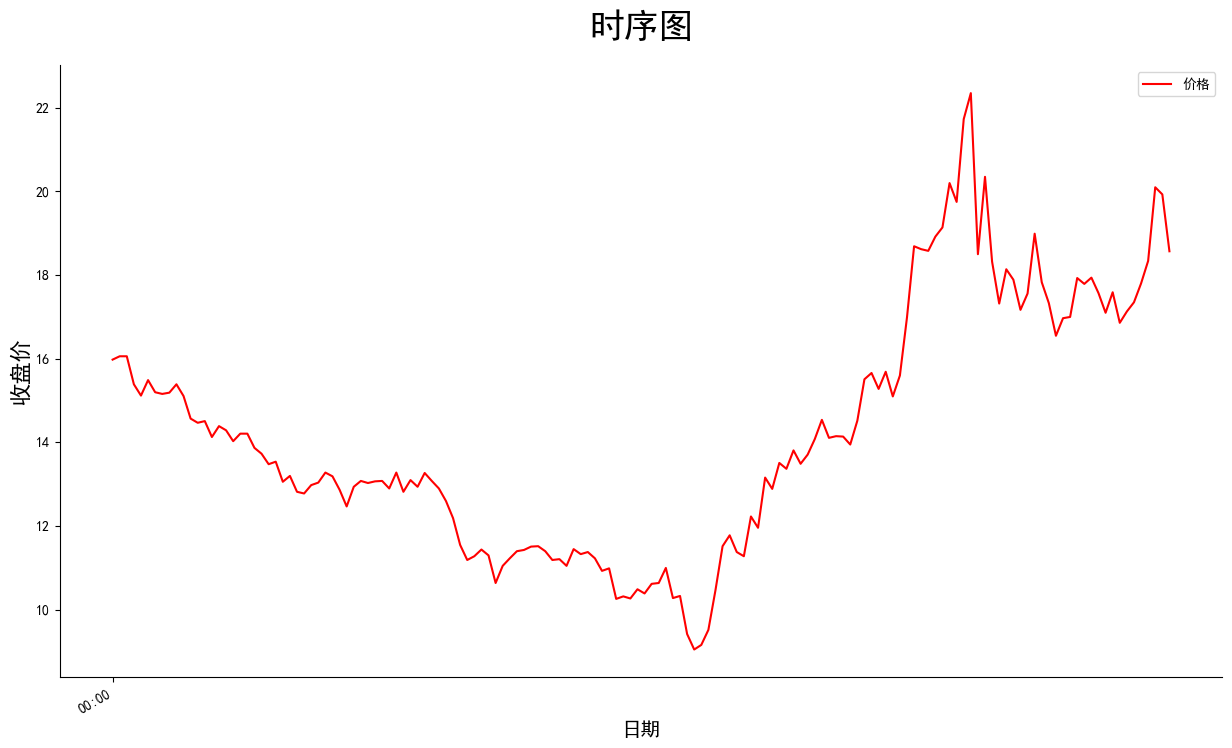

In [10]:
# 图片大小设置
fig = plt.figure(figsize=(15,9), dpi=100)
ax = fig.add_subplot(111)

# X轴时间刻度格式 & 刻度显示
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(pd.date_range(dataUtil.index[0],dataUtil.index[-1],freq='H'), rotation=45)

# 绘图
plt.plot(dataUtil.index,dataUtil,color='r', label='价格')

# 辅助线
# sup_line = [9 for i in range(480)]
# ax.plot(dataUtil.index, sup_line, color='black', linestyle='--', linewidth='1', label='辅助线')

plt.xlabel('日期', fontsize=14)    # X轴标签
plt.ylabel("收盘价", fontsize=16)         # Y轴标签
ax.legend()                              # 图例
plt.title("时序图", fontsize=25, color='black', pad=20)
plt.gcf().autofmt_xdate()

# 隐藏-上&右边线
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# plt.savefig('speed.png')
# plt.show()
plt.savefig('./time series graph.png')

## 差分平稳化处理

### 一阶差分

In [11]:
data['price_diff1'] = data['收盘价'].diff(1)
data = data.dropna(inplace=False)
diff_shift_ts = data.shift(1)

data

C:\Users\localAdmin\AppData\Local\Temp\ipykernel_1920\1029150385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_diff1'] = data['收盘价'].diff(1)


,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值,price_diff1
1,2021-12-22,'000625,长安汽车,16.06,16.24,16.01,16.07,15.98,0.08,0.5006,0.9882,57806231,9.298260e+08,1.223038e+11,9.394426e+10,0.08
2,2021-12-23,'000625,长安汽车,16.06,16.16,15.95,16.13,16.06,0.0,0.0,1.0187,59588780,9.553644e+08,1.223038e+11,9.394426e+10,0.00
3,2021-12-24,'000625,长安汽车,15.39,16.14,15.30,16.12,16.06,-0.67,-4.1719,2.0057,117325893,1.826746e+09,1.171855e+11,9.002504e+10,-0.67
4,2021-12-27,'000625,长安汽车,15.12,15.46,14.80,15.30,15.39,-0.27,-1.7544,1.4601,85411864,1.290471e+09,1.151296e+11,8.844566e+10,-0.27
5,2021-12-28,'000625,长安汽车,15.49,15.52,15.08,15.20,15.12,0.37,2.4471,1.1709,68491282,1.047284e+09,1.179469e+11,9.061000e+10,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2022-07-28,'000625,长安汽车,17.80,18.31,17.21,17.47,17.35,0.45,2.5937,4.386,333534226,5.942254e+09,1.766080e+11,1.353593e+11,0.45
146,2022-07-29,'000625,长安汽车,18.34,18.51,17.61,17.80,17.80,0.54,3.0337,5.0166,381485655,6.935122e+09,1.819658e+11,1.394657e+11,0.54
147,2022-08-01,'000625,长安汽车,20.10,20.10,18.01,18.40,18.34,1.76,9.5965,6.7784,515463044,9.929775e+09,1.994282e+11,1.528495e+11,1.76
148,2022-08-02,'000625,长安汽车,19.93,20.59,19.00,19.66,20.10,-0.17,-0.8458,6.4033,486934323,9.638677e+09,1.977415e+11,1.515568e+11,-0.17


In [12]:
dataUtil = data.iloc[:, -1]
dataUtil

1      0.08
2      0.00
3     -0.67
4     -0.27
5      0.37
       ... 
145    0.45
146    0.54
147    1.76
148   -0.17
149   -1.36
Name: price_diff1, Length: 149, dtype: float64

## 自相关系数

In [13]:
#原始序列单位根检测
print(u'原始序列的adf、P_value、usedlag、nobs、critical values、icbest、regresults、resstore 结果为：',
      ADF(data['收盘价'],maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False))

#差分序列单位根检测
print(u'原始序列的adf、P_value、usedlag、nobs、critical values、icbest、regresults、resstore 结果为：',
      ADF(data['price_diff1'],maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False))

原始序列的adf、P_value、usedlag、nobs、critical values、icbest、regresults、resstore 结果为： (-2.1688303455685745, 0.7447833189721877, 7, 141, {'1%': -4.455236650956168, '5%': -3.874944830924854, '10%': -3.5795035175820957}, 274.6129437988926)
原始序列的adf、P_value、usedlag、nobs、critical values、icbest、regresults、resstore 结果为： (-3.9615702003502933, 0.035136290571496934, 6, 142, {'1%': -4.454630091433345, '5%': -3.8746401679188405, '10%': -3.579316526412991}, 277.4594370462214)


自相关系数acf： [ 1.         -0.15141542  0.00126647  0.11204472 -0.14106882 -0.06658521
  0.08807737  0.14337772 -0.03804188  0.06164705  0.00130035 -0.01563089
 -0.06402756 -0.04423523  0.02556886 -0.01153939 -0.06585276  0.10710296
  0.10356145 -0.18561106  0.04360632  0.11823022]


C:\Users\localAdmin\AppData\Local\Temp\ipykernel_1920\1720023024.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(data[u'price_diff1'],lags=60).show() # 其中lags参数是指横坐标最大取值


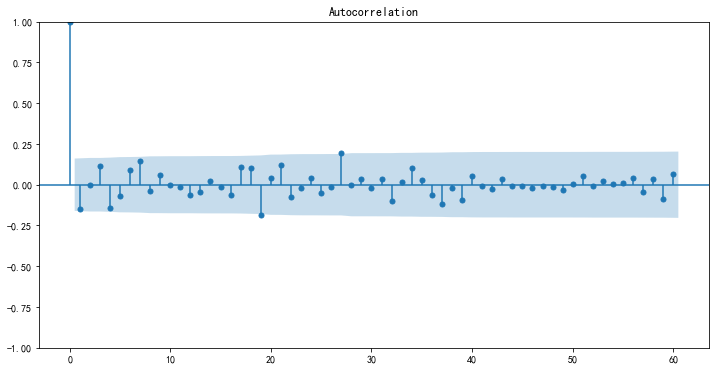

In [14]:
print("自相关系数acf：",acf(data[u'price_diff1']))
plot_acf(data[u'price_diff1'],lags=60).show() # 其中lags参数是指横坐标最大取值

偏自相关系数pacf： [ 1.         -0.1524385  -0.02247608  0.11382197 -0.11422883 -0.11163375
  0.05773613  0.21546709  0.01318032  0.00994677 -0.01011292  0.05845383
 -0.05998424 -0.10732764 -0.0201058   0.01989643 -0.10453027  0.05961888
  0.17998622 -0.13173438 -0.0585972   0.17935583]


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\localAdmin\AppData\Local\Temp\ipykernel_1920\4285433219.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(data[u'price_diff1'],lags=60).show()


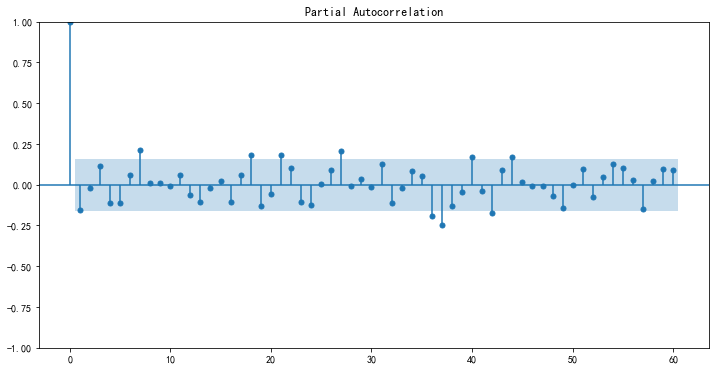

In [15]:
print("偏自相关系数pacf：",pacf(data[u'price_diff1']))
plot_pacf(data[u'price_diff1'],lags=60).show()

In [16]:
print(u'原始序列的白噪声检验结果为：', acorr_ljungbox(data.收盘价, lags=[1,2,3,4,5,6,7,8])) #返回统计量和p值
print(u'处理后序列的白噪声检验结果为：', acorr_ljungbox(data.price_diff1, lags=[1,2,3,4,5,6,7,8]))

原始序列的白噪声检验结果为：       lb_stat      lb_pvalue
1  141.897741   1.023861e-32
2  275.725097   1.339849e-60
3  401.734914   9.318775e-87
4  520.334228  2.677789e-111
5  633.912344  9.497292e-135
6  743.924517  2.000537e-157
7  849.470784  3.899785e-179
8  949.023978  1.497616e-199
处理后序列的白噪声检验结果为：      lb_stat  lb_pvalue
1   3.485312   0.061916
2   3.485558   0.175033
3   5.420166   0.143492
4   8.508024   0.074644
5   9.200742   0.101320
6  10.421292   0.107995
7  13.678446   0.057205
8  13.909369   0.084158


## 模型拟合

In [17]:
def get_score(y_pred, y_true):
    print('MAE:', mean_absolute_error(y_true, y_pred))
    print('R2:', r2_score(y_true, y_pred))
    print('MSE:', mean_squared_error(y_true, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('MAPE:', np.mean(np.abs((y_pred-y_true)/y_true)))

In [18]:
train = dataUtil[:144]
test = dataUtil[144:]
train, test

(1      0.08
 2      0.00
 3     -0.67
 4     -0.27
 5      0.37
        ... 
 140   -0.47
 141    0.49
 142   -0.73
 143    0.27
 144    0.22
 Name: price_diff1, Length: 144, dtype: float64,
 145    0.45
 146    0.54
 147    1.76
 148   -0.17
 149   -1.36
 Name: price_diff1, dtype: float64)

In [43]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	size = len(X) - 5
	train_tmp, test_tmp = X[:size], X[size:]
	# history = [x for x in train]
	# make predictions
	# predictions = list()
	# for t in range(len(test)):
		# model = ARIMA(history, order=arima_order)
		# model_fit = model.fit(disp=0)
		# yhat = model_fit.forecast()[0]
	tmp_model = ARIMA(train_tmp, order=arima_order).fit()
	tmp_pred = tmp_model.forecast(5)
		# predictions.append(yhat)
		# history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(tmp_pred, test_tmp)
	return error

In [44]:
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [45]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = [0,1]
q_values = [0, 1, 2, 4, 6, 8, 10]
evaluate_models(train, p_values, d_values, q_values)

F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignore

ARIMA(0, 0, 0) MSE=0.224
ARIMA(0, 0, 1) MSE=0.236
ARIMA(0, 0, 2) MSE=0.247
ARIMA(0, 0, 4) MSE=0.165


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

ARIMA(0, 0, 6) MSE=0.219
ARIMA(0, 0, 8) MSE=0.204


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

ARIMA(0, 0, 10) MSE=0.198
ARIMA(0, 1, 0) MSE=0.327
ARIMA(0, 1, 1) MSE=0.228
ARIMA(0, 1, 2) MSE=0.246


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

ARIMA(0, 1, 4) MSE=0.244
ARIMA(0, 1, 6) MSE=0.176


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

ARIMA(0, 1, 8) MSE=0.193


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(0, 1, 10) MSE=0.187
ARIMA(1, 0, 0) MSE=0.241
ARIMA(1, 0, 1) MSE=0.241
ARIMA(1, 0, 2) MSE=0.246


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

ARIMA(1, 0, 4) MSE=0.166
ARIMA(1, 0, 6) MSE=0.207


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 8) MSE=0.201


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(1, 0, 10) MSE=0.217
ARIMA(1, 1, 0) MSE=0.284
ARIMA(1, 1, 1) MSE=0.252
ARIMA(1, 1, 2) MSE=0.250


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

ARIMA(1, 1, 4) MSE=0.189
ARIMA(1, 1, 6) MSE=0.194


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(1, 1, 8) MSE=0.201


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(1, 1, 10) MSE=0.207
ARIMA(2, 0, 0) MSE=0.241
ARIMA(2, 0, 1) MSE=0.243


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 0, 2) MSE=0.255


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 0, 4) MSE=0.247


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 6) MSE=0.189


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 0, 8) MSE=0.307


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 0, 10) MSE=0.258
ARIMA(2, 1, 0) MSE=0.207
ARIMA(2, 1, 1) MSE=0.248
ARIMA(2, 1, 2) MSE=0.202


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 1, 4) MSE=0.257


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 1, 6) MSE=0.243


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 1, 8) MSE=0.217


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(2, 1, 10) MSE=0.103
ARIMA(4, 0, 0) MSE=0.190
ARIMA(4, 0, 1) MSE=0.190


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 0, 2) MSE=0.250


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 0, 4) MSE=0.280


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 0, 6) MSE=109.630


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 0, 8) MSE=0.211


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 0, 10) MSE=0.161
ARIMA(4, 1, 0) MSE=0.206
ARIMA(4, 1, 1) MSE=0.194


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(4, 1, 2) MSE=0.191


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(4, 1, 4) MSE=0.230


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 1, 6) MSE=0.220


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 1, 8) MSE=0.207


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(4, 1, 10) MSE=0.327
ARIMA(6, 0, 0) MSE=0.241


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(6, 0, 1) MSE=0.238


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(6, 0, 2) MSE=0.230


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 0, 4) MSE=0.232


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 0, 6) MSE=0.213


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 0, 8) MSE=0.242


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 0, 10) MSE=0.174
ARIMA(6, 1, 0) MSE=0.181


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(6, 1, 1) MSE=0.183


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(6, 1, 2) MSE=0.168


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 1, 4) MSE=0.222


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 1, 6) MSE=0.245


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 1, 8) MSE=0.236


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(6, 1, 10) MSE=0.225
ARIMA(8, 0, 0) MSE=0.184


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(8, 0, 1) MSE=0.191


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

ARIMA(8, 0, 2) MSE=0.190


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 0, 4) MSE=0.116


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 0, 6) MSE=0.192


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 0, 8) MSE=0.212


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 0, 10) MSE=0.169
ARIMA(8, 1, 0) MSE=0.185


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(8, 1, 1) MSE=0.187


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

ARIMA(8, 1, 2) MSE=0.191


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 1, 4) MSE=0.186


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 1, 6) MSE=0.102


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 1, 8) MSE=0.193


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(8, 1, 10) MSE=0.129
ARIMA(10, 0, 0) MSE=0.182


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignore

ARIMA(10, 0, 1) MSE=0.194


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

ARIMA(10, 0, 2) MSE=0.189


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 0, 4) MSE=0.124


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 0, 6) MSE=0.161


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 0, 8) MSE=0.159


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 0, 10) MSE=0.169
ARIMA(10, 1, 0) MSE=0.160


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

ARIMA(10, 1, 1) MSE=0.189


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

ARIMA(10, 1, 2) MSE=0.190


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 1, 4) MSE=0.113


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 1, 6) MSE=0.198


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

ARIMA(10, 1, 8) MSE=0.181
ARIMA(10, 1, 10) MSE=0.117
Best ARIMA(8, 1, 6) MSE=0.102


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [46]:
best_model = ARIMA(train, order=(8, 1, 6)).fit()
best_pred = best_model.forecast(5)
get_score(best_pred, test)
best_pred,test

F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

MAE: 0.8823977956123583
R2: -0.06980421578304474
MSE: 1.1067167404444238
RMSE: 1.0520060553268806
MAPE: 0.9419435365581181


F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\APPLICATIONS\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(144    0.117384
 145   -0.259985
 146   -0.035829
 147    0.093502
 148   -0.139943
 Name: predicted_mean, dtype: float64,
 145    0.45
 146    0.54
 147    1.76
 148   -0.17
 149   -1.36
 Name: price_diff1, dtype: float64)

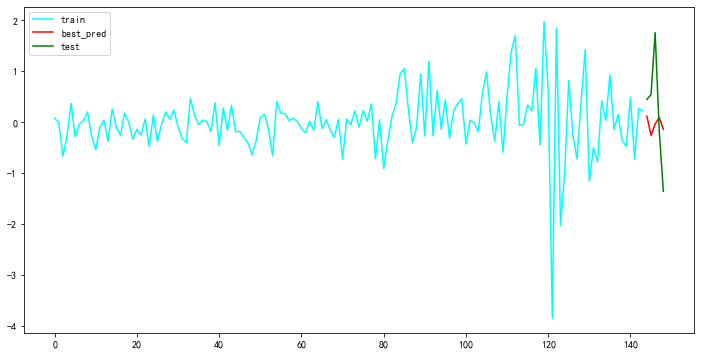

In [53]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(dataUtil.shape[0])
plt.plot(x[:144], train, label='train', c='cyan')
plt.plot(x[144:], best_pred, label='best_pred', c='red')
plt.plot(x[144:], test, label='test', c='green')
plt.legend()
plt.show()

## 模型评估

### 模型信息

In [48]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            price_diff1   No. Observations:                  144
Model:                 ARIMA(8, 1, 6)   Log Likelihood                -127.429
Date:                Thu, 04 Aug 2022   AIC                            284.857
Time:                        05:15:59   BIC                            329.300
Sample:                             0   HQIC                           302.916
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1975      0.413     -0.478      0.633      -1.007       0.612
ar.L2         -0.1326      0.332     -0.399      0.690      -0.784       0.518
ar.L3         -0.1161      0.311     -0.373      0.709      -0.726       0.494
ar.L4          0.2246      0.264      0.850      0.395      -0.293       0.743
ar.L5         -0.4808      0.289     -1.662      0.096      -1.048       0.086
ar.L6          0.0153      0.120      0.128      0.898      -0.220       0.250
ar.L7          0.1751      0.113      1.551      0.121      -0.046       0.396
ar.L8          0.1793      0.125      1.434      0.151      -0.066       0.424
ma.L1         -0.9827      0.425     -2.311      0.021      -1.816      -0.149
ma.L2          0.2307      0.426      0.541      0.588      -0.605       1.066
ma.L3         -0.0056      0.320     -0.018      0.986      -0.632       0.621
ma.L4         -0.6509      0.301     -2.163      0.031      -1.241      -0.061
ma.L5          0.9646      0.418      2.309      0.021       0.146       1.783
ma.L6         -0.5358      0.332     -1.615      0.106      -1.186       0.115
sigma2         0.3356      0.035      9.657      0.000       0.268       0.404
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               898.43
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               9.22   Skew:                            -1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 残差分析

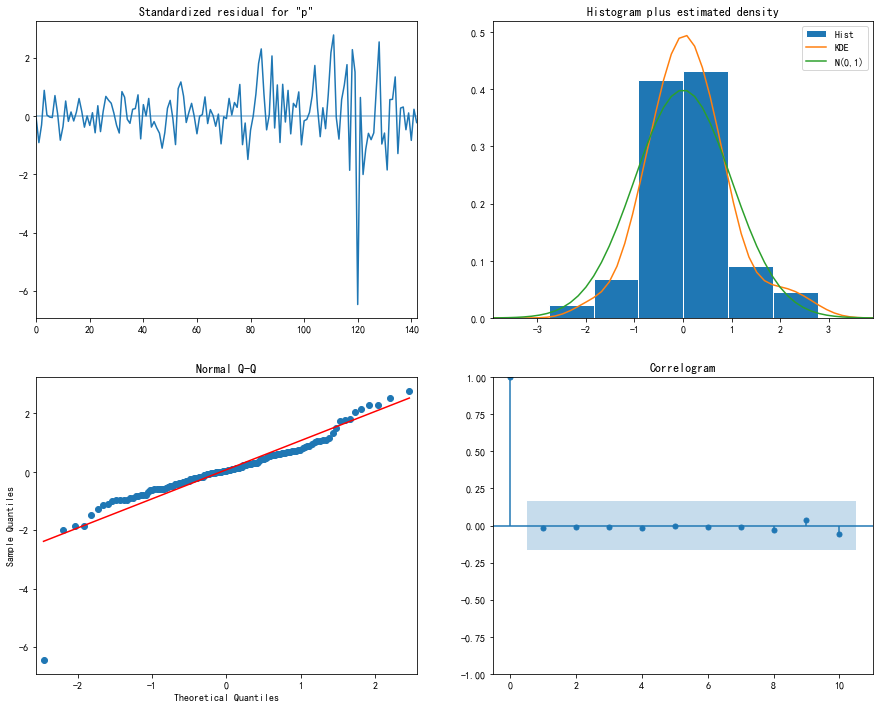

In [49]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

### 统计学参数

In [51]:
get_score(best_pred, test)

MAE: 0.8823977956123583
R2: -0.06980421578304474
MSE: 1.1067167404444238
RMSE: 1.0520060553268806
MAPE: 0.9419435365581181
